In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import scipy.stats as stats
from scipy.optimize import curve_fit
import scipy.io as sio

from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import  matplotlib.markers as mark


from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib import cm

import os
from os.path import expanduser

import torch
import pickle


import sys
sys.path.append('../../')
from src.utils import load_model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
ft = 10
# graphical properties
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': ft})
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams["font.family"] = "Helvetica"


save_fig_path = expanduser("~") + '/research/data/projects/rnn_timescales/neurips_23/'

col_sig_par = '#D48A6A' #, if too light #AA5B39
col_sig_dms = '#803515'

col_multi_par =  '#74AE97' #, if too light #277455
col_multi_dms =  '#0E573A'

# Load data

In [4]:
num_neurons = 500
NET_SIZE = [num_neurons]

INPUT_SIZE = 1
NUM_CLASSES = 2
BIAS = True
NUM_READOUT_HEADS = 100
TRAIN_TAU = True


## load taus

In [5]:
def compute_mean_std_tau(device, data_path, save_path, curriculum_type, task, network_number, N_max_range,\
                         T, num_neurons, num_trials, max_lag, fit_lag, burn_T, strict=False,\
                         mod_model=False, mod_afunc=torch.nn.LeakyReLU, affixes=[]):
    
    
    # setting N_min
    if curriculum_type == 'cumulative':
        N_min = 2
    elif curriculum_type == 'single':
        N_min = N
    elif 'sliding_' in curriculum_type:
        N_min = N - 10 + 1 # 10 is the number of heads
    else:
        raise ValueError('Unknown curriculum_type.')
    
    tau_mean_mean = np.zeros(len(N_max_range))
    tau_mean_std = np.zeros(len(N_max_range))
    tau_std_mean = np.zeros(len(N_max_range))
    tau_std_std = np.zeros(len(N_max_range))
    for i, N in enumerate(N_max_range):
        taus_all_N = []
        taus_net_avg = np.zeros(len(net_ids))
        taus_net_std = np.zeros(len(net_ids))
        for j, net_id in enumerate(net_ids):
            network_name = 'network_'+str(net_id)
            
            # loading the network 
            rnn = load_model(curriculum_type = curriculum_type, task = task, network_number = network_number,\
                             N_max = N, N_min = N_min, device=device, base_path = data_path, strict = strict,\
                             mod_model = mod_model, mod_afunc = mod_afunc, affixes = affixes)
            
            taus = rnn.taus[0].detach().numpy()
            taus_all_N = np.concatenate((taus_all_N, taus))

            taus_net_avg[j] = np.mean(taus)
            taus_net_std[j] = np.std(taus)
        

        tau_mean_mean[i] = np.mean(taus_net_avg)
        tau_std_mean[i] = np.std(taus_net_avg)
        tau_mean_std[i] = np.mean(taus_net_std)
        tau_std_std[i] = np.std(taus_net_std)
        
#         tau_std[i] = np.mean(taus_net_std)
#         tau_std[i] = np.std(taus_net_avg)
#         tau_mean[i] = np.mean(taus_all_N)
#         tau_std[i] = np.std(taus_all_N)
        
        
    return tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std

<ErrorbarContainer object of 3 artists>

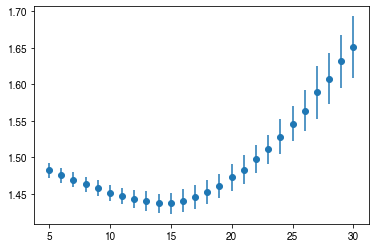

In [7]:
path = expanduser("~") + '/research/data/projects/rnn_timescales/ac/ac_tau_loc_nonlin_correct/'

net_ids = np.arange(1,5)
N_range = np.arange(5,31,1)
sub_dir = ''
net_type = 0

tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  = compute_mean_std_tau(path, net_type, net_ids, N_range, sub_dir)
plt.errorbar(N_range, tau_mean_mean, yerr = tau_std_mean, fmt = 'o')

In [8]:
final_N_singlehead_trained = np.array([37, 33, 35, 35])
final_N_singlehead_tau1 = np.array([24, 25, 24, 26])
final_N_singlehead_tau2 = np.array([26, 25, 26, 26])
final_N_singlehead_tau3 = np.array([25, 24, 24, 24])
final_N_singlehead_tau4 = np.array([24,23, 23, 23])

final_N_singlehead_tau = [final_N_singlehead_tau1,
                          final_N_singlehead_tau2,
                          final_N_singlehead_tau3]



In [9]:
final_N_multihead_trained = np.array([100, 101, 100, 101])
final_N_multihead_tau1 = np.array([101, 101, 101, 101])
final_N_multihead_tau2 = np.array([87, 88, 87, 87])
final_N_multihead_tau3 = np.array([66, 70, 70, 72])
final_N_multihead_tau5 = np.array([50])

final_N_multihead_tau = [final_N_multihead_tau1,
                          final_N_multihead_tau2,
                          final_N_multihead_tau3]

# Plot

In [10]:
col_sig_par = '#D48A6A' #, if too light #AA5B39
col_sig_dms = '#803515'

col_multi_par =  '#74AE97' #, if too light #277455
col_multi_dms =  '#0E573A'

In [11]:
def plot_shade(x, mean, std, color):
    ax.fill_between(
        x,
        mean - std,
        mean + std,
        color=color,
        alpha=0.2,
    )

In [13]:
# loading panels

# single DMS
path = expanduser("~") + '/research/projects/rnn_timescales_local/Hel/n_bit_parity/models_bDMS_complete/'
N_range = np.arange(2,94,1)
sub_dir = 'train_curr_1_at_a_time_with_forgetting_1_bDMS_'
net_type = 2
tau_mean_mean_sing_dms, tau_mean_std_sing_dms,  tau_std_mean_sing_dms, tau_std_std_sing_dms  = \
compute_mean_std_tau(path, net_type, net_ids, N_range, sub_dir)

# single N-parity
path = expanduser("~") + '/research/projects/rnn_timescales_local/Hel/n_bit_parity/models_tau_train/'
N_range = np.arange(2,33,1)
sub_dir = ''
net_type = 0
tau_mean_mean_sing_par, tau_mean_std_sing_par,  tau_std_mean_sing_par, tau_std_std_sing_par  = \
compute_mean_std_tau(path, net_type, net_ids, N_range, sub_dir)

# multi DMS
path = expanduser("~") + '/research/projects/rnn_timescales_local/Hel/n_bit_parity/models_bDSM/multi_head/'
N_range = np.arange(2,100,1)
sub_dir = 'train_curr_cumulative_1_heads_bDMS_'
net_type = 3
tau_mean_mean_multi_dms, tau_mean_std_multi_dms,  tau_std_mean_multi_dms, tau_std_std_multi_dms  = \
compute_mean_std_tau(path, net_type, net_ids, N_range, sub_dir)

# multi N-parity
path = expanduser("~") + '/research/projects/rnn_timescales_local/Hel/n_bit_parity/models_multi_head/'
N_range = np.arange(2,100,1)
sub_dir = 'train_curr_cumulative_1_heads_'
net_type = 1
tau_mean_mean_multi_par, tau_mean_std_multi_par,  tau_std_mean_multi_par, tau_std_std_multi_par  = \
compute_mean_std_tau(path, net_type, net_ids, N_range, sub_dir)

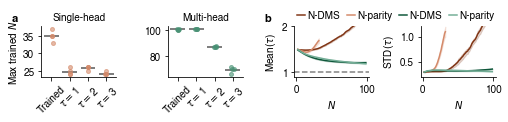

In [14]:
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(18*cm, 4.5*cm))


alpha_dot = 0.6
w = 0.35 #width of mean line
ms = 8
lw = 2

x_text = -.4
y_text = 1.1

x_noise = 0.05
c_singlehead = '#D48A6A'
c_multihead = '#489174'
#c_trained = '#5A78E6'

ax = plt.subplot(141)
ax.text(x_text,y_text,'a',color='k',fontsize=ft+1,weight='bold', transform=ax.transAxes)

ax.plot([-w, w], 2*[np.mean(final_N_singlehead_trained)], 'k', alpha=0.5, lw=lw)
ax.plot(x_noise * np.random.randn(len(final_N_singlehead_trained)), final_N_singlehead_trained,
             '.', c=c_singlehead, ms=ms, alpha=alpha_dot)

[ax.plot([1 + i - w, 1 + i + w], 2 * [np.mean(final_N_singlehead_tau[i])], 'k', lw=lw, alpha=0.5) for i in range(len(final_N_singlehead_tau))]
[ax.plot(1 + i + x_noise * np.random.randn(len(final_N_singlehead_tau[i])), final_N_singlehead_tau[i],
              '.', c=c_singlehead, ms=ms, alpha=alpha_dot) for i in range(len(final_N_singlehead_tau))]

ax.set_xticks([0, 1, 2, 3], ['Trained', r'$ \tau = $'+ str(1), r'$ \tau = $'+ str(2), r'$ \tau = $'+ str(3)],\
              rotation=45)
ax.set_ylabel(r'Max trained $N$')
ax.set_title('Single-head', fontsize = ft)


#######################

ax = plt.subplot(142)
ax.plot([-w, w], 2*[np.mean(final_N_multihead_trained)], 'k', alpha=0.5, lw=lw)
ax.plot(x_noise * np.random.randn(len(final_N_multihead_trained)), final_N_multihead_trained,
             '.', c=c_multihead, ms=ms, alpha=alpha_dot)

[ax.plot([1 + i - w, 1 + i + w], 2 * [np.mean(final_N_multihead_tau[i])], 'k', lw=lw, alpha=0.5) for i in range(len(final_N_multihead_tau))]
[ax.plot(1 + i + x_noise * np.random.randn(len(final_N_multihead_tau[i])), final_N_multihead_tau[i],
              '.', c=c_multihead, ms=ms, alpha=alpha_dot) for i in range(len(final_N_multihead_tau))]

# ax.set_xticks([0, 1, 2, 3, 4], ['Trained', r'$ \tau= $' + str(1), r'$ \tau= $'+ str(1),\
#                                 r'$ \tau= $'+ str(3)],\rotation=45)
ax.set_xticks([0, 1, 2, 3], ['Trained', r'$ \tau = $'+ str(1), r'$ \tau = $'+ str(2), r'$ \tau = $'+ str(3)],\
              rotation=45)
# axes[1].set_ylabel('Max N')
# ax.set_ylabel(r'Max trained $N$')
ax.set_title('Multi-head', fontsize = ft)


#--------------------------------------------------------------------------------------------------

ms = 3
lw = 1.5
elw = 1.5

y1 = .9
y2 = 2

ax = plt.subplot(143)
ax.text(x_text,y_text,'b',color='k',fontsize=ft+1,weight='bold', transform=ax.transAxes)

net_ids = np.arange(1,5)


# DMS
N_range = np.arange(2,94,1)
plt.plot(N_range, tau_mean_mean_sing_dms, lw = lw, color = col_sig_dms, label = 'N-DMS')
plot_shade(N_range, tau_mean_mean_sing_dms, tau_std_mean_sing_dms, col_sig_dms)

# parity
N_range = np.arange(2,33,1)
plt.plot(N_range, tau_mean_mean_sing_par, lw = lw, color = col_sig_par, label = 'N-parity')
plot_shade(N_range, tau_mean_mean_sing_par, tau_std_mean_sing_par, col_sig_par)

plt.ylabel(r'Mean($\tau$)')
# plt.xlabel(r'$N$')
# plt.title('Single-head', fontsize = ft)
plt.ylim([y1, y2])

ax = plt.subplot(143)
net_ids = np.arange(1,5)
ax.axhline(y = 1, ls = '--', color = 'gray')

#DMS
N_range = np.arange(2,100,1)
plt.plot(N_range, tau_mean_mean_multi_dms, lw = lw, color = col_multi_dms, label = 'N-DMS')
plot_shade(N_range, tau_mean_mean_multi_dms, tau_std_mean_multi_dms, col_multi_dms)

# parity
N_range = np.arange(2,100,1)
plt.plot(N_range, tau_mean_mean_multi_par, lw = lw, color = col_multi_par, label = 'N-parity')
plot_shade(N_range, tau_mean_mean_multi_par, tau_std_mean_multi_par, col_multi_par)


fig.tight_layout()
# plt.legend(frameon = False, loc = 'upper right', bbox_to_anchor=(1,1.1))
plt.xlabel(r'$N$')
# plt.title('Multi-head', fontsize = ft)
plt.ylabel(r'Mean($\tau$)')
plt.xlabel(r'$N$')
plt.ylim([y1, y2])

#-------------------------------------------------------------------------------------------------------

ax = plt.subplot(144)
net_ids = np.arange(1,5)

y1 = 0.2
y2 = 1.2

# DMS
N_range = np.arange(2,94,1)
plt.plot(N_range, tau_mean_std_sing_dms, lw = lw, color = col_sig_dms, label = 'N-DMS')
plot_shade(N_range, tau_mean_std_sing_dms, tau_std_std_sing_dms, col_sig_dms)

# parity
N_range = np.arange(2,33,1)
plt.plot(N_range, tau_mean_std_sing_par, lw = lw, color = col_sig_par, label = 'N-parity')
plot_shade(N_range, tau_mean_std_sing_par, tau_std_std_sing_par, col_sig_par)
plt.ylim([y1, y2])

# plt.legend(frameon = False, loc = 'upper left', bbox_to_anchor=(0,1.1))
plt.ylabel(r'STD($\tau$)')
# plt.xlabel(r'$N$')
# plt.title('Single-head', fontsize = ft)

ax = plt.subplot(144)
net_ids = np.arange(1,5)

# DMS
N_range = np.arange(2,100,1)
plt.plot(N_range, tau_mean_std_multi_dms, lw = lw, color = col_multi_dms, label = 'N-DMS')
plot_shade(N_range, tau_mean_std_multi_dms, tau_std_std_multi_dms, col_multi_dms)

# parity
N_range = np.arange(2,100,1)
plt.plot(N_range, tau_mean_std_multi_par, lw = lw, color = col_multi_par, label = 'N-parity')
plot_shade(N_range, tau_mean_std_multi_par, tau_std_std_multi_par, col_multi_par)

# plt.legend(frameon = False, loc = 'upper right', bbox_to_anchor=(1,1.1))
plt.ylabel(r'STD($\tau$)')
plt.xlabel(r'$N$')
# plt.title('Multi-head', fontsize = ft)
plt.ylim([y1, y2])
plt.legend(frameon = False, loc = 'upper right', bbox_to_anchor=(1.1,1.5),\
           handletextpad= 0.2, handlelength = 0.8, ncol = 4, columnspacing=0.7)


# fig.tight_layout()

sns.despine()

In [15]:
# fig.savefig(save_fig_path +'fig_training_taus_v3.pdf')